# HOW TO USE
* Libraries, Data sections just set it up
* Pipeline for Baseline starts at Section 3


# 1. Libraries

In [16]:
# Import Libraries #
import json
from pprint import pprint
from pandas import *
from pandas.io.json import json_normalize

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# General libraries
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# SK-learn libraries for pre/processing data
from sklearn import preprocessing

from sklearn.decomposition import LatentDirichletAllocation as LDA

# SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# SK-learn libraries for evaluation
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score



# 2. Standard Data

## 2.1 Raw Data 

In [5]:
## Get Data ##

#reference on data: https://www.kaggle.com/c/random-acts-of-pizza/data

# pull in the training and test data
#with open('/Users/Jen2/Desktop/W207/project/train.json', encoding='utf-8') as data_file:
with open('/home/levi/Documents/W207_Proj/data/train.json', encoding='utf-8') as data_file:
    trainData = json.loads(data_file.read())   
#with open('/Users/Jen2/Desktop/W207/project/test.json', encoding='utf-8') as data_file:
with open('/home/levi/Documents/W207_Proj/data/train.json', encoding='utf-8') as data_file:
    testData = json.loads(data_file.read())    

# create a dev data set 
devData = trainData[0:1000]
trainData = trainData[1000:]

# show how the data looks in its original format
#pprint("data in json format:")
#pprint(trainData[1])

# create a normalized view
allTData = json_normalize(trainData)
#print("\nSize of the normalized Data:", allTData.shape)
#print("\nnormalized data columns:", list(allTData))

allDData = json_normalize(devData)


## 2.2 Parsing Data

In [6]:
## Create subsets of data for analysis ###

# create a flat dataset without the subreddits list
flatData = allTData.drop('requester_subreddits_at_request', 1)
# create a separate dataset with just subreddits, indexed on request id
# we can creata a count vector on the words, run Naive Bayes against it, 
# and add the probabilities to our flat dataset
subredTData = allTData[['request_id','requester_subreddits_at_request']]
subredTData.set_index('request_id', inplace=True)

subredDData= allDData[['request_id','requester_subreddits_at_request']]
subredDData.set_index('request_id', inplace=True)

# our training labels
trainLabel = allTData['requester_received_pizza']

devLabel = allDData['requester_received_pizza']

# what do these look like?
#print(list(flatData))
#print(subredTData.shape)
#print(subredTData['requester_subreddits_at_request'][1])

# create a corpus of subreddits to vectorize
trainCorpus = []
for index in range(len(subredTData)):
    trainCorpus.append(' '.join(subredTData['requester_subreddits_at_request'][index]))

devCorpus = []
for index in range(len(subredDData)):
    devCorpus.append(' '.join(subredDData['requester_subreddits_at_request'][index]))
    


In [7]:
# combine all text sources into a single corpus
fldTText = allTData[['request_id','request_text', 'request_text_edit_aware', 'request_title']]
fldDText = allDData[['request_id','request_text', 'request_text_edit_aware', 'request_title']]

trainCorpus = []
for index in range(len(subredTData)):
    a = ' '.join(subredTData['requester_subreddits_at_request'][index])
    b = (a, fldTText['request_text'][index], fldTText['request_text_edit_aware'][index],
        fldTText['request_title'][index])
    trainCorpus.append(' '.join(b))

devCorpus = []
for index in range(len(subredDData)):
    a = ' '.join(subredDData['requester_subreddits_at_request'][index])
    b = (a, fldDText['request_text'][index], fldDText['request_text_edit_aware'][index],
         fldDText['request_title'][index])
    devCorpus.append(' '.join(b))

# Print 3 examples  
#print (trainCorpus[:3])
labels = trainLabel.astype(int)
labels = list(labels)
#print(labels[:3])
#print('-'*75)

#print ('\n' , devCorpus[:3])
labels_dev = devLabel.astype(int)
labels_dev = list(labels_dev)
#print(labels_dev[:3])

**TEXT : trainCorpus and devCorpus **

## 2.3 Vectorize Corpus (no pre-processing)

In [8]:
# Set up the data with CountVectorizer

#vectorizer = CountVectorizer(lowercase=True, strip_accents='unicode',stop_words='english')

vectorizer = CountVectorizer(min_df=1,lowercase=True)
tVector = vectorizer.fit_transform(trainCorpus)
dVector = vectorizer.transform(devCorpus)

print ('\nRaw data:')
print ("The size of the vocabulary for the training text data is", tVector.shape[1])
print ("First 5 feature Names:", vectorizer.get_feature_names()[1:6], "\n")

vectorizer = TfidfVectorizer(min_df=1)
tVector_p = vectorizer.fit_transform(trainCorpus)
dVector_p = vectorizer.transform(devCorpus)

print ('\nTf-id data:')
print ("The size of the vocabulary for the training text data is", tVector_p.shape[1])
print ("First 5 feature Names:", vectorizer.get_feature_names()[1:6], "\n")


Raw data:
The size of the vocabulary for the training text data is 17213
First 5 feature Names: ['000', '0000', '0011011001111000', '00243364', '00pm'] 


Tf-id data:
The size of the vocabulary for the training text data is 17213
First 5 feature Names: ['000', '0000', '0011011001111000', '00243364', '00pm'] 



# Benchmark Models for Evaluation
# Input - tVector (trainCorpus), dVector (devCorpus) or with _p TDIF vectorizer

## Useful Functions for Evaluation

In [9]:
def roc_curve1(y_true, y_pred_prob):
    """This function plots the ROC curve
    Inputs: y_true, correct label
            y_pred_prob, predicted probabilities
    """
    fpr, tpr, thr = roc_curve(y_true, y_pred_prob)
   
    plt.figure()
    plt.plot(fpr,tpr)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC Curve")
    plt.show()
    

def score_rep(y_true, y_pred, desc):
    """Function to print out comprehensive report for classification test
    Inputs: y_true, correct label
            y_pred, predicted label from model
            desc, description of model
    Output: classification report
    """
    print(desc)
    print("-"*75)
    print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
    print("Area under curve of ROC: ", metrics.roc_auc_score(y_true, y_pred))
    print("Classification report:\n")
    print(metrics.classification_report(y_true, y_pred))
    print("-"*75)
    


# Logistic Regressions

Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.736
Area under curve of ROC:  0.528482328482
Classification report:

             precision    recall  f1-score   support

      False       0.75      0.96      0.84       740
       True       0.46      0.10      0.16       260

avg / total       0.68      0.74      0.67      1000

---------------------------------------------------------------------------


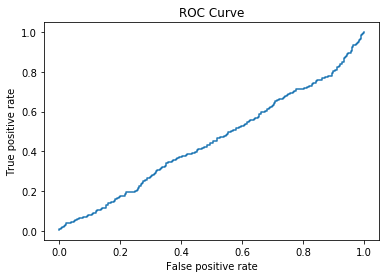

Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.74
Area under curve of ROC:  0.5
Classification report:

             precision    recall  f1-score   support

      False       0.74      1.00      0.85       740
       True       0.00      0.00      0.00       260

avg / total       0.55      0.74      0.63      1000

---------------------------------------------------------------------------


/home/levi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


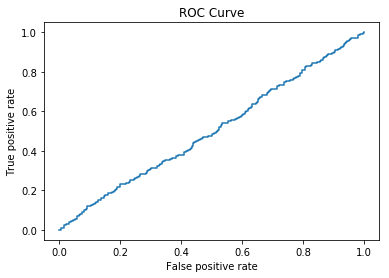

In [13]:
# Logistic Regression

C = 0.01 #(For now)

modelLogit = LogisticRegression(penalty='l2', C=C)

modelLogit.fit(tVector,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector),'Logistic Regression, C = 0.01')
roc_curve1(devLabel, modelLogit.predict_proba(dVector)[:,0])


modelLogit.fit(tVector_p,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector_p),'Logistic Regression, C = 0.01')
roc_curve1(devLabel, modelLogit.predict_proba(dVector_p)[:,0])




# Naive Bayes

Naive Bayes, alpha = 0.01
---------------------------------------------------------------------------
Accuracy:  0.719
Area under curve of ROC:  0.556912681913
Classification report:

             precision    recall  f1-score   support

      False       0.77      0.89      0.82       740
       True       0.42      0.22      0.29       260

avg / total       0.68      0.72      0.69      1000

---------------------------------------------------------------------------


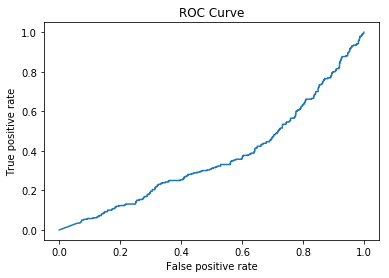

Naive Bayes, alpha = 0.01
---------------------------------------------------------------------------
Accuracy:  0.719
Area under curve of ROC:  0.556912681913
Classification report:

             precision    recall  f1-score   support

      False       0.77      0.89      0.82       740
       True       0.42      0.22      0.29       260

avg / total       0.68      0.72      0.69      1000

---------------------------------------------------------------------------


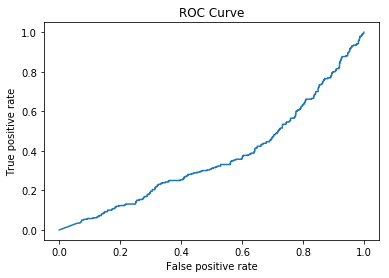

In [14]:
# Multinomial NB

alpha = 0.01

clf = BernoulliNB(alpha=alpha)

clf.fit(tVector, trainLabel)
score_rep(devLabel, clf.predict(dVector),'Naive Bayes, alpha = 0.01')
roc_curve1(devLabel, clf.predict_proba(dVector)[:,0])


clf.fit(tVector_p, trainLabel)
score_rep(devLabel,clf.predict(dVector_p),'Naive Bayes, alpha = 0.01')
roc_curve1(devLabel, clf.predict_proba(dVector_p)[:,0])


# Random Forest

Random Forest
---------------------------------------------------------------------------
Accuracy:  0.739
Area under curve of ROC:  0.501819126819
Classification report:

             precision    recall  f1-score   support

      False       0.74      1.00      0.85       740
       True       0.40      0.01      0.02       260

avg / total       0.65      0.74      0.63      1000

---------------------------------------------------------------------------


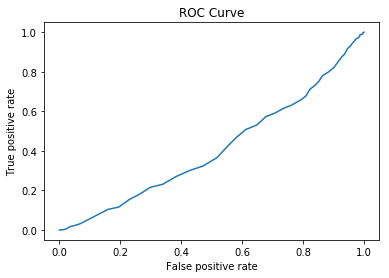

Random Forest
---------------------------------------------------------------------------
Accuracy:  0.74
Area under curve of ROC:  0.5
Classification report:

             precision    recall  f1-score   support

      False       0.74      1.00      0.85       740
       True       0.00      0.00      0.00       260

avg / total       0.55      0.74      0.63      1000

---------------------------------------------------------------------------


/home/levi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


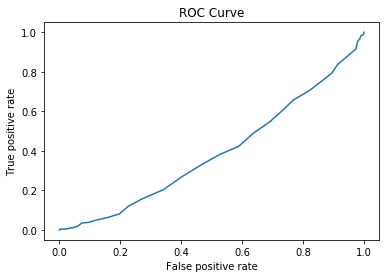

In [17]:
RF = RandomForestClassifier(n_estimators=100)

RF.fit(tVector, trainLabel)
score_rep(devLabel, RF.predict(dVector),'Random Forest')
roc_curve1(devLabel, RF.predict_proba(dVector)[:,0])


RF.fit(tVector_p, trainLabel)
score_rep(devLabel,RF.predict(dVector_p),'Random Forest')
roc_curve1(devLabel, RF.predict_proba(dVector_p)[:,0])